<a href="https://colab.research.google.com/github/KrabMads/FinanceStuff/blob/main/ETF_Rotation_Popft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ETF Rotation strategy based on Mean-Variance, Value At Risk and Sharpe Ratio**

In [ ]:
!pip install yfinance pyportfolioopt datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#%% [code]
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date, timedelta
import math
from dateutil.relativedelta import relativedelta
from google.colab import files
from pandas.tseries.offsets import BDay
from pandas.tseries.offsets import BMonthEnd

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import DiscreteAllocation
from pypfopt import objective_functions
from pypfopt import EfficientCVaR
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import CLA

import cvxpy as cp

**To do:**
1. Create a equal-weighted benchmark
2. Plot all optimizing methods in same graph

In [ ]:
Telecom = 'vox'
Consumer_Staples = 'XLP'
Industrials = 'XLI'
Consumer_Discretionary = 'XLY'
Utilities = 'XLU'
Materials = 'GDX'
Financials = 'XLF'
RealEstate = 'VNQ'
Energy = 'XLE'
Healthcare = 'XLV'
Technology = 'QQQ'
MSCI_World = 'XWD.TO'

In [ ]:
last_business_day = pd.bdate_range(end=datetime.date.today(), periods=1, freq='BM')[0]
last_business_day

Timestamp('2022-11-30 00:00:00', freq='BM')

In [ ]:
assets = ['vox', 'XLP', 'XLI', 'XLY','XLU','GDX', 'XLF', 'VNQ', 'XLE','XLV','QQQ','XWD.TO']
assets.sort()

try: initial_weights
except NameError: initial_weights = None
if initial_weights is None:
  initial_weights = np.array([1/len(assets)] * len(assets))  #Equally initial weights
else:
  initial_weights = initial_weights

df_var = pd.DataFrame()
df_sharp = pd.DataFrame()
df_CVaR = pd.DataFrame()

Backtest_months = 48

#DateOffset.rollback()
offset = BMonthEnd() #Offset to businessmonthend

for x in range(0,Backtest_months,1):
  n = x
  #One_month = date.today()-BDay(1) + relativedelta(months=-n)
  #One_month = last_business_day + relativedelta(months=-n) 
  if n == 0:
    #One_month = last_business_day
    One_month = pd.bdate_range(end=last_business_day, periods=n+1, freq='BM')[0]
  else:
    One_month = pd.bdate_range(end=last_business_day, periods=n+1, freq='BM')[0]

  end_string = One_month.strftime("%Y-%m-%d")
  start = One_month - relativedelta(months=+24)
  start_string = start.strftime("%Y-%m-%d")
  

  data = yf.download(assets, start=start_string, end=end_string)
  data = data.loc[:,('Adj Close', slice(None))]
  data.columns = assets
  
  Y = data.pct_change().dropna()
  mu = expected_returns.mean_historical_return(data)
  S = risk_models.exp_cov(data)
  returns = expected_returns.returns_from_prices(data).dropna()

  MinVol = EfficientFrontier(mu, S, weight_bounds=(0, 0.125))      #Minimum/Maximum position size
  SR = EfficientFrontier(mu, S, weight_bounds=(0, 0.125))      #Minimum/Maximum position size
  CVaR = EfficientCVaR(mu, returns, weight_bounds=(0, 0.125))      #Minimum/Maximum position size

  MinVol.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01) #TransactionCosts
  SR.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01) #TransactionCosts
  CVaR.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01) #TransactionCosts

#BTC-USD should have weight of greater than 0.15
#  BTC_USD = MinVol.tickers.index("BTC-USD")
#  MinVol.add_constraint(lambda w: w[BTC_USD] >= 0.15)

  #Solving!
  MinVol.min_volatility()
  MinVolWeights = MinVol.clean_weights()

  SR.max_sharpe()
  SRWeights = SR.clean_weights()

  CVaR.min_cvar()
  CVaRWeights = CVaR.clean_weights()

  
  #SRWeights
  sharp = pd.DataFrame([SRWeights.values()], columns=SRWeights)
  sharp["Dato"] = end_string
  sharp.set_index('Dato', inplace=True, drop=True)
  df_sharp = df_sharp.append(sharp)
  #CVaRWeights
  CVaR = pd.DataFrame([CVaRWeights.values()], columns=CVaRWeights)
  CVaR["Dato"] = end_string
  CVaR.set_index('Dato', inplace=True, drop=True)
  df_CVaR = df_var.append(CVaR)
  #MinVolWeights
  var = pd.DataFrame([MinVolWeights.values()], columns=MinVolWeights)
  var["Dato"] = end_string
  var.set_index('Dato', inplace=True, drop=True)
  df_var = df_var.append(var)
  

  #print(MinVolWeights)
  #print(SRWeights)
  #print(CVaRWeights)
  #print('Rebalancing date:', end_string)
  #print(initial_weights)

print(df_sharp)
#print(df_var)
#print(df_CVaR)
df_var.to_csv('MinVol.csv')

#files.download('df_var.csv')

[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


[*********************100%***********************]  12 of 12 completed
                GDX      QQQ      VNQ    XLE      XLF      XLI      XLP  \
Dato                                                                      
2022-11-30  0.00000  0.00000  0.12500  0.000  0.12500  0.12500  0.12500   
2022-10-31  0.00000  0.00000  0.12500  0.000  0.12500  0.12500  0.12500   
2022-09-30  0.00000  0.00000  0.12500  0.000  0.12500  0.12500  0.12500   
2022-08-31  0.00000  0.00000  0.12500  0.000  0.12500  0.12500  0.12500   
2022-07-29  0.00000  0.00000  0.12500  0.000  0.12500  0.12500  0.12500   
2022-06-30  0.00000  0.00000  0.12500  0.000  0.12500  0.12500  0.12500   
2022-05-31  0.00000  0.00000  0.12500  0.000  0.12500  0.12500  0.12500   
2022-04-29  0.00000  0.01758  0.12500  0.000  0.12500  0.12500  0.12500   
2022-03-31  0.12500  0.08524  0.02748  0.000  0.12500  0.12500  0.12500   
2022-02-28  0.12498  0.12500  0.00000  0.000  0.12500  0.12500  0.01634   
2022-01-31  0.00000  0.12500 

/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


In [ ]:
One_month = date.today()-BDay(1) + relativedelta(months=-0)
end_string = One_month.strftime("%Y-%m-%d")
start = One_month - relativedelta(months=+Backtest_months-1)
start_string = start.strftime("%Y-%m-%d")

assets = ['vox', 'XLP', 'XLI', 'XLY','XLU','GDX', 'XLF', 'VNQ', 'XLE','XLV','QQQ','XWD.TO']
assets.sort()

# Downloading data
data = yf.download(assets, start=start_string, end=end_string)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets
#data.columns = ['Telecom','Consumer_Staples','Industrials','Consumer_Discretionary','Utilities','Materials','Financials','RealEstate','Energy','Healthcare','Technology', 'BTC', 'VIX', 'GOLD']
data
ETF_Return = data.pct_change()
ETF_Return

[*********************100%***********************]  12 of 12 completed


,GDX,QQQ,VNQ,XLE,XLF,XLI,XLP,XLU,XLV,XLY,XWD.TO,vox
Date,,,,,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,0.020428,-0.032670,0.006991,-0.013460,-0.009918,-0.022481,-0.030429,-0.005745,-0.000192,-0.020305,-0.021652,-0.023461
2019-01-04,-0.008380,0.042785,0.011707,0.041470,0.034024,0.033220,0.037916,0.021319,0.014808,0.029831,0.033094,0.022702
2019-01-07,-0.012206,0.011905,0.009823,0.009338,0.014865,0.001237,0.008135,-0.001366,-0.006822,0.003839,0.022612,-0.001293
2019-01-08,0.000475,0.009046,0.020653,0.016962,0.007735,0.000823,0.013703,0.009181,0.012402,0.007765,0.011056,0.007553
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25,-0.009404,-0.006578,0.006359,-0.005052,-0.003687,0.003334,0.003865,0.000656,0.005813,0.005941,0.000561,0.004855
2022-11-28,-0.040084,-0.014673,-0.026769,-0.016386,-0.027430,-0.017170,-0.018164,-0.003803,-0.010290,-0.007510,-0.006170,-0.006946
2022-11-29,0.031136,-0.007570,0.016527,-0.000117,0.015109,0.005917,0.006133,-0.003818,-0.007406,-0.002498,-0.003175,0.004561


In [ ]:
return_dates = pd.DataFrame(ETF_Return.index)
return_dates = return_dates.set_index('Date')

In [ ]:
df_sharp.index = pd.DatetimeIndex(df_sharp.index) #Fix datetime so its identical

df_all = return_dates.append(df_sharp, ignore_index=False, sort = False)
df_all.head(10)

,GDX,QQQ,VNQ,XLE,XLF,XLI,XLP,XLU,XLV,XLY,XWD.TO,vox
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_all.index = pd.to_datetime(df_all.index)   #set index to datetime
df_all = df_all.sort_index()                  #sort index
df_all.tail(50)

,GDX,QQQ,VNQ,XLE,XLF,XLI,XLP,XLU,XLV,XLY,XWD.TO,vox
2022-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-30,0.0,0.0,0.125,0.0,0.125,0.125,0.125,0.125,0.125,0.125,0.0,0.125
2022-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Now fill weights using the forward fill method 
df_all = df_all.fillna(method="ffill")
df_all.head(60)

,GDX,QQQ,VNQ,XLE,XLF,XLI,XLP,XLU,XLV,XLY,XWD.TO,vox
2018-12-31,0.12500,0.125,0.0000,0.0,0.0,0.00381,0.12119,0.125,0.125,0.125,0.125,0.125
2019-01-02,0.12500,0.125,0.0000,0.0,0.0,0.00381,0.12119,0.125,0.125,0.125,0.125,0.125
2019-01-03,0.12500,0.125,0.0000,0.0,0.0,0.00381,0.12119,0.125,0.125,0.125,0.125,0.125
2019-01-04,0.12500,0.125,0.0000,0.0,0.0,0.00381,0.12119,0.125,0.125,0.125,0.125,0.125
2019-01-07,0.12500,0.125,0.0000,0.0,0.0,0.00381,0.12119,0.125,0.125,0.125,0.125,0.125
2019-01-08,0.12500,0.125,0.0000,0.0,0.0,0.00381,0.12119,0.125,0.125,0.125,0.125,0.125
2019-01-09,0.12500,0.125,0.0000,0.0,0.0,0.00381,0.12119,0.125,0.125,0.125,0.125,0.125
2019-01-10,0.12500,0.125,0.0000,0.0,0.0,0.00381,0.12119,0.125,0.125,0.125,0.125,0.125
2019-01-11,0.12500,0.125,0.0000,0.0,0.0,0.00381,0.12119,0.125,0.125,0.125,0.125,0.125
2019-01-14,0.12500,0.125,0.0000,0.0,0.0,0.00381,0.12119,0.125,0.125,0.125,0.125,0.125


In [ ]:
df_all.index.duplicated()

array([False, False, False, ..., False,  True, False])

In [ ]:
df_all = df_all[~df_all.index.duplicated(keep='first')].iloc[2:,:]
df_all

,GDX,QQQ,VNQ,XLE,XLF,XLI,XLP,XLU,XLV,XLY,XWD.TO,vox
2019-01-03,0.125,0.125,0.000,0.0,0.000,0.00381,0.12119,0.125,0.125,0.125,0.125,0.125
2019-01-04,0.125,0.125,0.000,0.0,0.000,0.00381,0.12119,0.125,0.125,0.125,0.125,0.125
2019-01-07,0.125,0.125,0.000,0.0,0.000,0.00381,0.12119,0.125,0.125,0.125,0.125,0.125
2019-01-08,0.125,0.125,0.000,0.0,0.000,0.00381,0.12119,0.125,0.125,0.125,0.125,0.125
2019-01-09,0.125,0.125,0.000,0.0,0.000,0.00381,0.12119,0.125,0.125,0.125,0.125,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25,0.000,0.000,0.125,0.0,0.125,0.12500,0.12500,0.125,0.125,0.125,0.000,0.125
2022-11-28,0.000,0.000,0.125,0.0,0.125,0.12500,0.12500,0.125,0.125,0.125,0.000,0.125
2022-11-29,0.000,0.000,0.125,0.0,0.125,0.12500,0.12500,0.125,0.125,0.125,0.000,0.125
2022-11-30,0.000,0.000,0.125,0.0,0.125,0.12500,0.12500,0.125,0.125,0.125,0.000,0.125


In [ ]:
ETF_Return = ETF_Return.iloc[1:,:]
ETF_Return

,GDX,QQQ,VNQ,XLE,XLF,XLI,XLP,XLU,XLV,XLY,XWD.TO,vox
Date,,,,,,,,,,,,
2019-01-03,0.020428,-0.032670,0.006991,-0.013460,-0.009918,-0.022481,-0.030429,-0.005745,-0.000192,-0.020305,-0.021652,-0.023461
2019-01-04,-0.008380,0.042785,0.011707,0.041470,0.034024,0.033220,0.037916,0.021319,0.014808,0.029831,0.033094,0.022702
2019-01-07,-0.012206,0.011905,0.009823,0.009338,0.014865,0.001237,0.008135,-0.001366,-0.006822,0.003839,0.022612,-0.001293
2019-01-08,0.000475,0.009046,0.020653,0.016962,0.007735,0.000823,0.013703,0.009181,0.012402,0.007765,0.011056,0.007553
2019-01-09,0.012827,0.008150,-0.001436,-0.002401,0.015842,0.004936,0.006759,-0.009291,-0.006031,0.004485,0.005084,0.001071
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25,-0.009404,-0.006578,0.006359,-0.005052,-0.003687,0.003334,0.003865,0.000656,0.005813,0.005941,0.000561,0.004855
2022-11-28,-0.040084,-0.014673,-0.026769,-0.016386,-0.027430,-0.017170,-0.018164,-0.003803,-0.010290,-0.007510,-0.006170,-0.006946
2022-11-29,0.031136,-0.007570,0.016527,-0.000117,0.015109,0.005917,0.006133,-0.003818,-0.007406,-0.002498,-0.003175,0.004561


In [ ]:
df_all[~df_all.index.isin(ETF_Return.index)]    #Check if duplicates exists

,GDX,QQQ,VNQ,XLE,XLF,XLI,XLP,XLU,XLV,XLY,XWD.TO,vox


In [ ]:
weighted_returns = (df_all * ETF_Return)
port_ret = weighted_returns.sum(axis=1)
cumulative_ret = (port_ret + 1).cumprod()

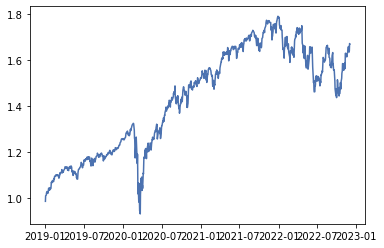

In [ ]:
plt.plot(cumulative_ret)

In [ ]:
cumulative_ret[-1]/cumulative_ret[0]-1

0.6931963599743165